# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [11]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [12]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [13]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [14]:
img_height=299
img_width=299
batch_size=64

In [15]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [16]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [17]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [18]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [19]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [20]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


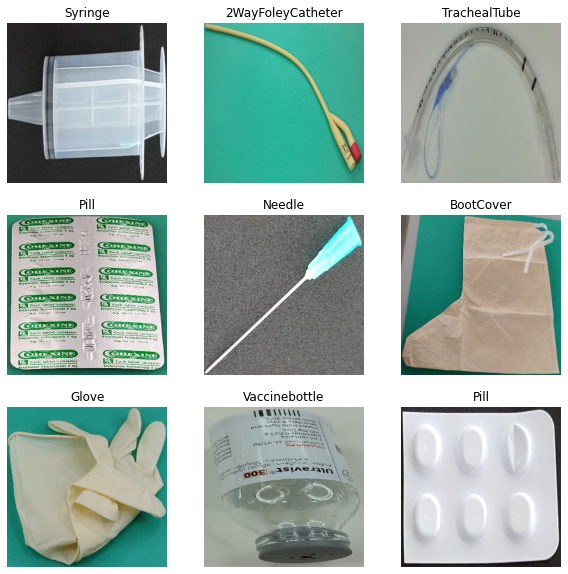

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [23]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [25]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [26]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [27]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [28]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


## Class Weight

In [30]:
y_train = np.concatenate([ y for x,y in train_ds],axis=0)

In [31]:
print(len(y_train))
print(y_train)

3095
[35 21 25 ... 25 18 26]


In [32]:
######################### Class Weight
from sklearn.utils import class_weight

# compute class weight 
# based on appearance of each class in y_trian
class_weight_value = class_weight.compute_class_weight(class_weight='balanced', classes=sorted(np.unique(y_train)), y=y_train)
# dict mapping
class_weight_value = {i : class_weight_value[i] for i, label in enumerate(sorted(np.unique(y_train)))}
print(class_weight_value)

{0: 5.806754221388368, 1: 2.220229555236729, 2: 2.040210942649967, 3: 4.193766937669377, 4: 1.9355847404627893, 5: 0.5510058750222538, 6: 4.440459110473458, 7: 2.156794425087108, 8: 2.287509238728751, 9: 1.9865211810012837, 10: 4.193766937669377, 11: 3.2820784729586427, 12: 2.695993031358885, 13: 2.156794425087108, 14: 3.9730423620025674, 15: 3.59465737514518, 16: 0.39730423620025673, 17: 4.717987804878049, 18: 0.3931656504065041, 19: 0.2755029375111269, 20: 1.451688555347092, 21: 1.3243474540008557, 22: 0.3682331945270672, 23: 1.5726626016260163, 24: 1.7555303460011344, 25: 0.46029149315883405, 26: 0.11685418711772257, 27: 0.9932605905006419, 28: 2.7958446251129176, 29: 4.440459110473458, 30: 2.516260162601626, 31: 1.0065040650406505, 32: 4.193766937669377, 33: 4.193766937669377, 34: 1.6061235080435912, 35: 2.516260162601626, 36: 0.5278867473989425, 37: 3.9730423620025674, 38: 3.774390243902439, 39: 0.6739982578397212, 40: 2.4350904799370574}


# Fitting

In [2]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/'

In [34]:
EPOCHS = 2000
save_model_interval = 10
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr],class_weight=class_weight_value)

Epoch 1/2000
49/49 [==============================] - 22s 337ms/step - loss: 2.3279 - accuracy: 0.5525 - val_loss: 1.1518 - val_accuracy: 0.7917
Epoch 2/2000
49/49 [==============================] - 9s 178ms/step - loss: 0.7395 - accuracy: 0.8737 - val_loss: 0.6986 - val_accuracy: 0.8616
Epoch 3/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.4180 - accuracy: 0.9170 - val_loss: 0.5201 - val_accuracy: 0.8862
Epoch 4/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.2834 - accuracy: 0.9389 - val_loss: 0.4230 - val_accuracy: 0.9069
Epoch 5/2000
49/49 [==============================] - 9s 177ms/step - loss: 0.2082 - accuracy: 0.9567 - val_loss: 0.3585 - val_accuracy: 0.9185
Epoch 6/2000
49/49 [==============================] - 9s 178ms/step - loss: 0.1610 - accuracy: 0.9706 - val_loss: 0.3150 - val_accuracy: 0.9379
Epoch 7/2000
49/49 [==============================] - 9s 178ms/step - loss: 0.1293 - accuracy: 0.9790 - val_loss: 0.2842 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

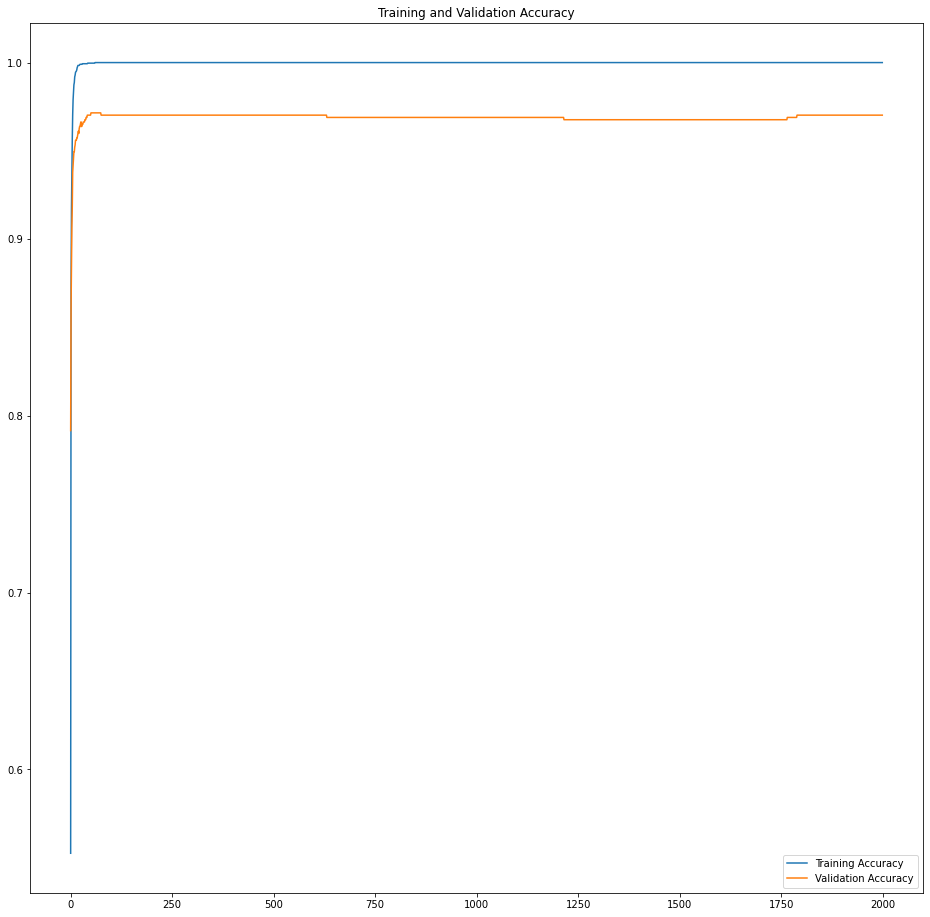

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


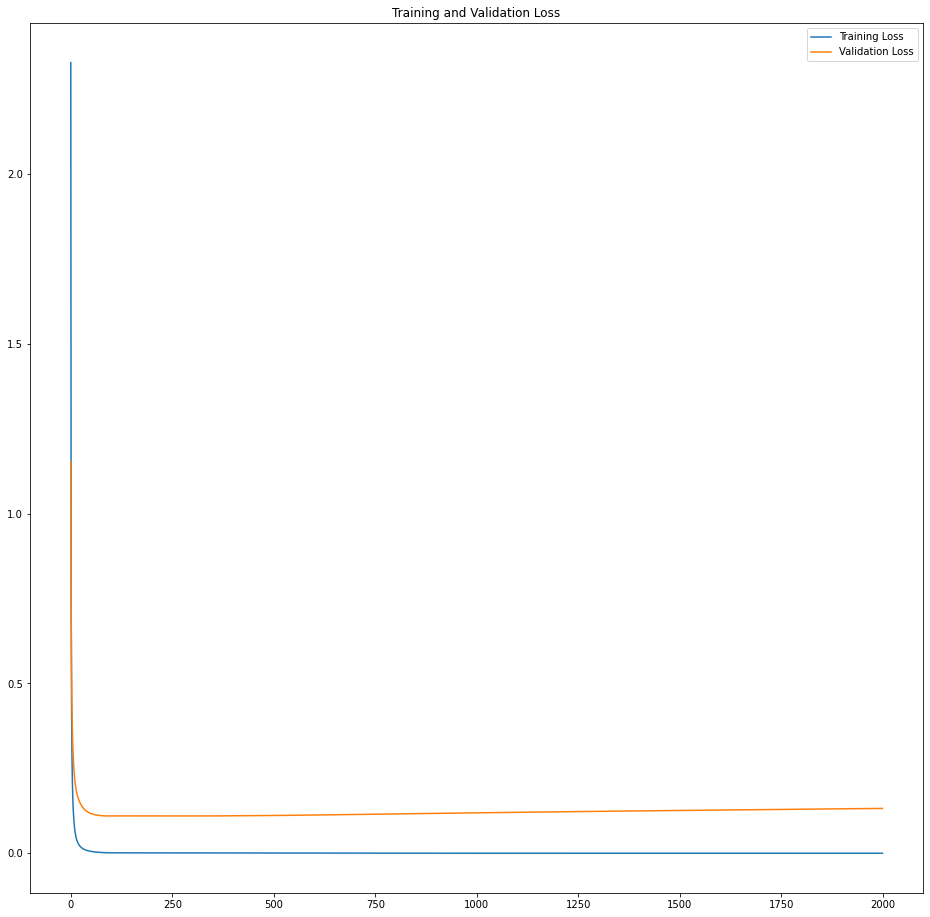

In [36]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [37]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 356ms/step - loss: 0.6504 - accuracy: 0.8618
test_indoor_ds_results:test loss, test acc: [0.6504480242729187, 0.8617614507675171]


In [38]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 27s 451ms/step - loss: 1.8563 - accuracy: 0.7404
test_outdoor_ds_results:test loss, test acc: [1.856259822845459, 0.7404458522796631]


In [39]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 9s 210ms/step - loss: 1.9358 - accuracy: 0.7040
test_belt_ds_results:test loss, test acc: [1.9358423948287964, 0.7039891481399536]


In [40]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0010-val_acc0.95.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0020-val_acc0.96.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0030-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0050-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer-ClassWeighted-NoAug-VerySlowLR2/OurOutputLayer-NoClassImbalanced-NoAug-epoch0060-val_acc0.

# Testing in testset

In [41]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 138ms/step - loss: 1.0755 - accuracy: 0.7035
Epoch010 
 test_indoor_acc=0.8478260636329651 
 test_outdoor_acc=0.7296178340911865 
 test_belt_acc=0.703535795211792
35/35 [==============================] - 5s 139ms/step - loss: 1.0818 - accuracy: 0.7031
Epoch020 
 test_indoor_acc=0.8567447066307068 
 test_outdoor_acc=0.7414012551307678 
 test_belt_acc=0.7030825018882751
35/35 [==============================] - 5s 139ms/step - loss: 1.1189 - accuracy: 0.7004
Epoch030 
 test_indoor_acc=0.8584169745445251 
 test_outdoor_acc=0.7426751852035522 
 test_belt_acc=0.7003626227378845
35/35 [==============================] - 5s 138ms/step - loss: 1.1627 - accuracy: 0.7013
Epoch040 
 test_indoor_acc=0.8589743375778198 
 test_outdoor_acc=0.740764319896698 
 test_belt_acc=0.701269268989563
35/35 [==============================] - 5s 141ms/step - loss: 1.2036 - accuracy: 0.6999
Epoch050 
 test_indoor_acc=0.8600891828536987 
 test_outdoor_acc=0.740127384662628

In [42]:
#Average
test_avg_acc = []
for i in range(len(test_indoor_acc)):
    tmp_avg = (test_indoor_acc[i] + test_outdoor_acc[i] + test_belt_acc[i]) / 3.0
    test_avg_acc.append(tmp_avg)

range(10, 2010, 10)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

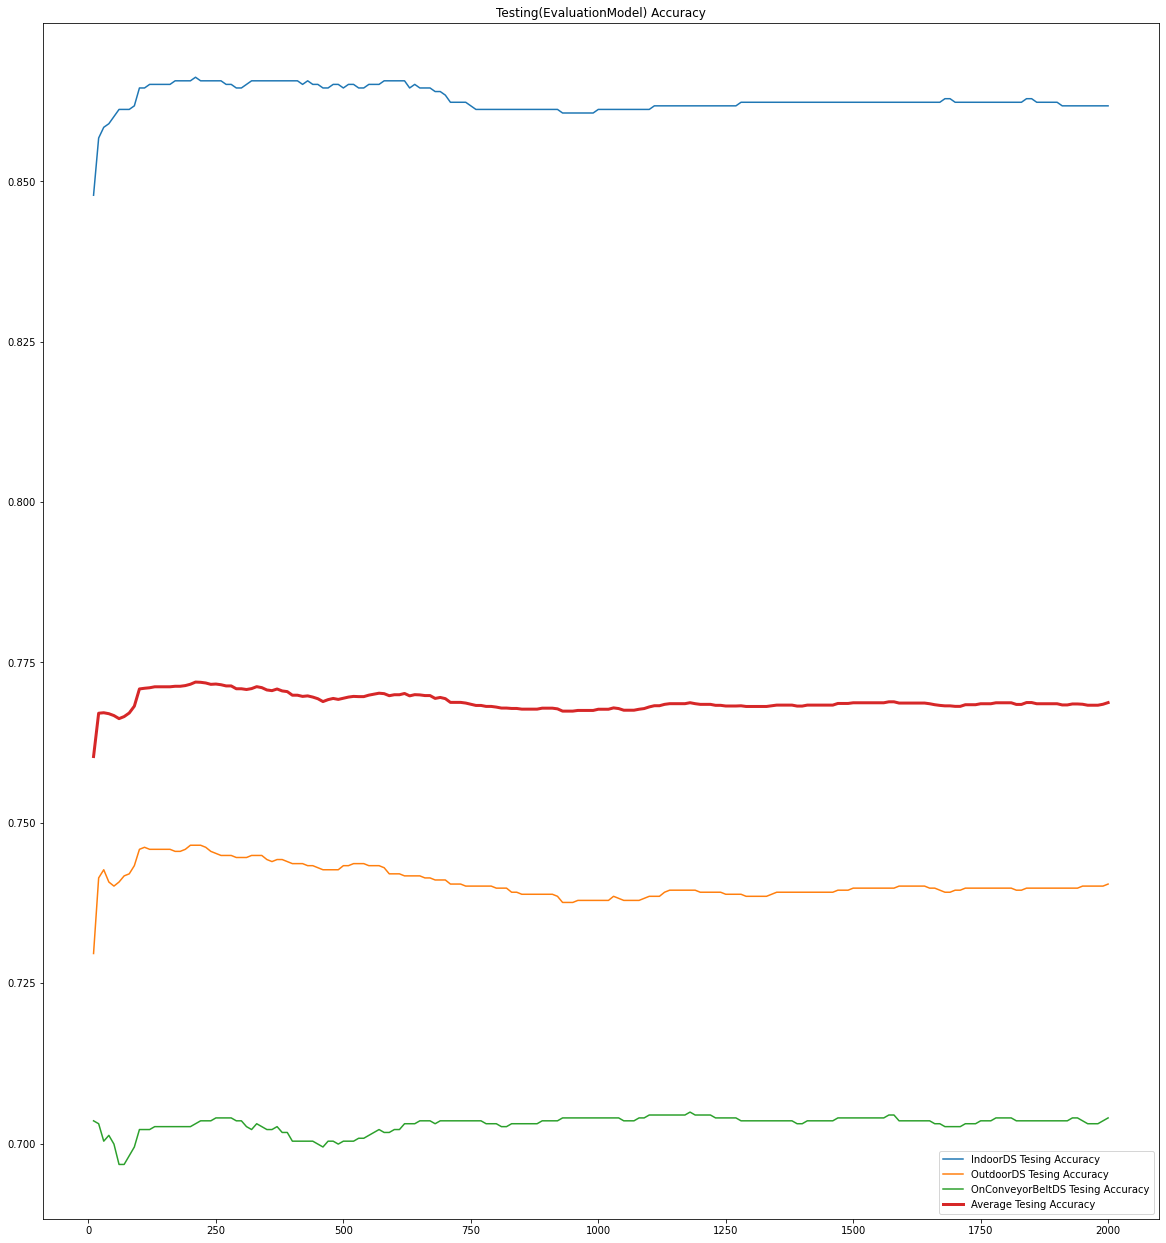

In [43]:
# loss / acc in each epoch graph ploting
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.plot(epochs_range, test_avg_acc, label='Average Tesing Accuracy',linewidth=3)
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

In [44]:
#Find Max Index and Value
print(f"max acc -> {max(test_avg_acc)}")
max_index = test_avg_acc.index(max(test_avg_acc))
print(f"max index -> {max_index}")
print(f"The [Epoch] of max acc -> {(max_index+1)*save_model_interval}")

max acc -> 0.7719333370526632
max index -> 20
The [Epoch] of max acc -> 210


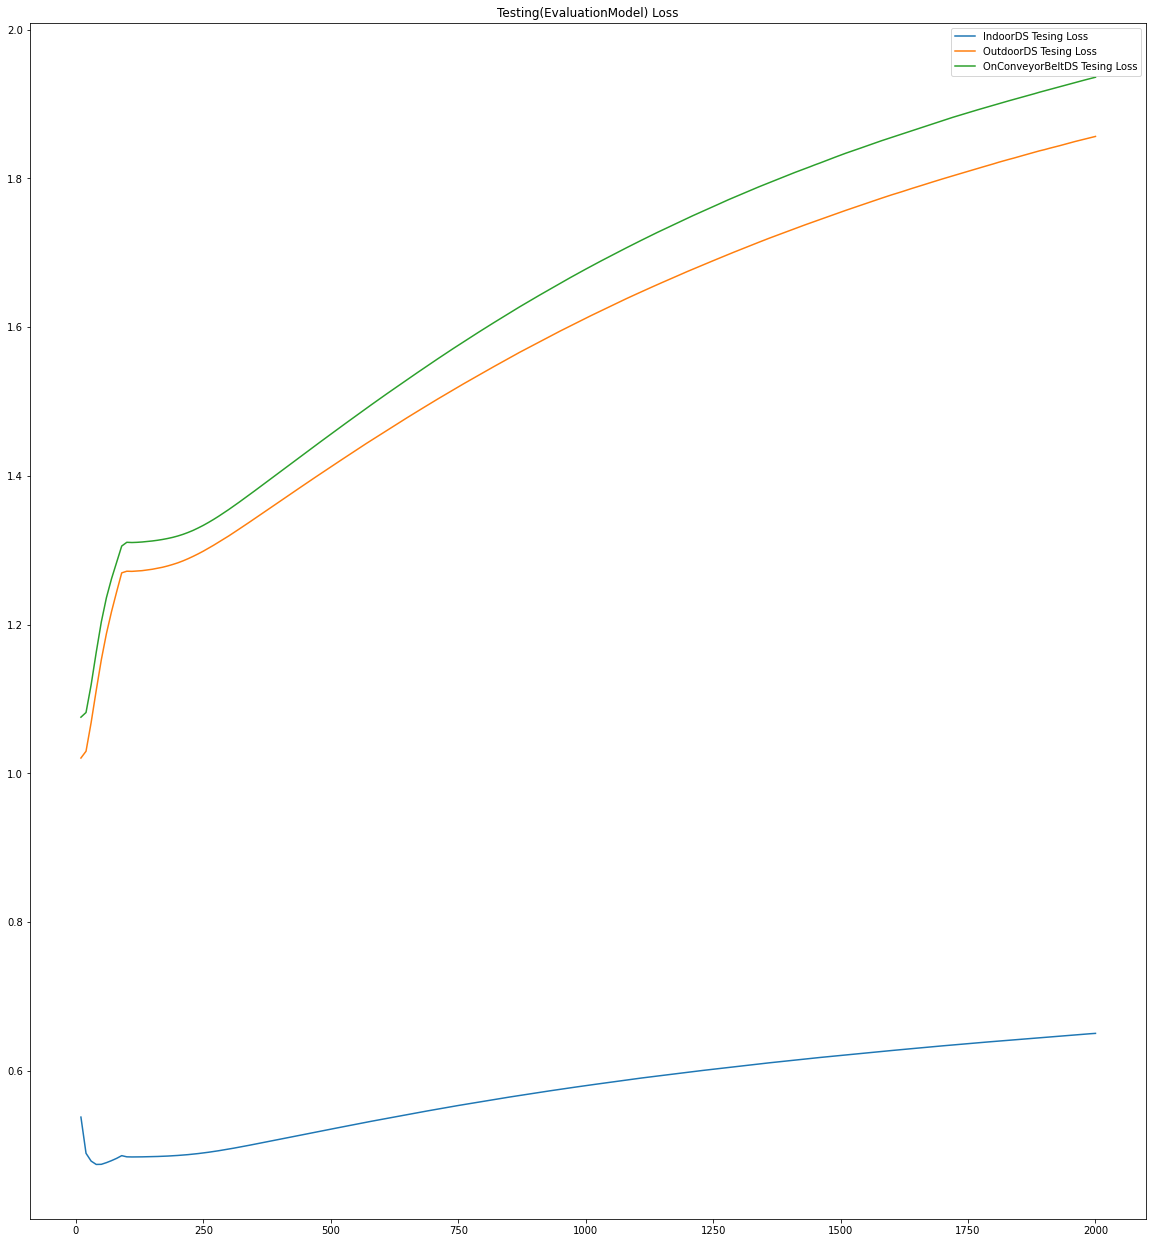

In [45]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [46]:
test_indoor_acc

[0.8478260636329651,
 0.8567447066307068,
 0.8584169745445251,
 0.8589743375778198,
 0.8600891828536987,
 0.8612040281295776,
 0.8612040281295776,
 0.8612040281295776,
 0.8617614507675171,
 0.8645485043525696,
 0.8645485043525696,
 0.865105926990509,
 0.865105926990509,
 0.865105926990509,
 0.865105926990509,
 0.865105926990509,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8662207126617432,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.865105926990509,
 0.865105926990509,
 0.8645485043525696,
 0.8645485043525696,
 0.865105926990509,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.8656633496284485,
 0.865105926990509,
 0.8656633496284485,
 0.865105926990509,
 0.865105926990509,
 0.8645485043525696,
 0.8645485043525696,
 0.865105926990509,
 0.8

In [47]:
test_outdoor_acc

[0.7296178340911865,
 0.7414012551307678,
 0.7426751852035522,
 0.740764319896698,
 0.7401273846626282,
 0.740764319896698,
 0.7417197227478027,
 0.7420381903648376,
 0.7433121204376221,
 0.7458598613739014,
 0.7461783289909363,
 0.7458598613739014,
 0.7458598613739014,
 0.7458598613739014,
 0.7458598613739014,
 0.7458598613739014,
 0.7455413937568665,
 0.7455413937568665,
 0.7458598613739014,
 0.7464967966079712,
 0.7464967966079712,
 0.7464967966079712,
 0.7461783289909363,
 0.7455413937568665,
 0.7452229261398315,
 0.7449044585227966,
 0.7449044585227966,
 0.7449044585227966,
 0.7445859909057617,
 0.7445859909057617,
 0.7445859909057617,
 0.7449044585227966,
 0.7449044585227966,
 0.7449044585227966,
 0.7442675232887268,
 0.7439490556716919,
 0.7442675232887268,
 0.7442675232887268,
 0.7439490556716919,
 0.743630588054657,
 0.743630588054657,
 0.743630588054657,
 0.7433121204376221,
 0.7433121204376221,
 0.7429936528205872,
 0.7426751852035522,
 0.7426751852035522,
 0.742675185203552

In [48]:
test_belt_acc

[0.703535795211792,
 0.7030825018882751,
 0.7003626227378845,
 0.701269268989563,
 0.6999093294143677,
 0.6967361569404602,
 0.6967361569404602,
 0.6980960965156555,
 0.6994560360908508,
 0.7021758556365967,
 0.7021758556365967,
 0.7021758556365967,
 0.7026292085647583,
 0.7026292085647583,
 0.7026292085647583,
 0.7026292085647583,
 0.7026292085647583,
 0.7026292085647583,
 0.7026292085647583,
 0.7026292085647583,
 0.7030825018882751,
 0.703535795211792,
 0.703535795211792,
 0.703535795211792,
 0.7039891481399536,
 0.7039891481399536,
 0.7039891481399536,
 0.7039891481399536,
 0.703535795211792,
 0.703535795211792,
 0.7026292085647583,
 0.7021758556365967,
 0.7030825018882751,
 0.7026292085647583,
 0.7021758556365967,
 0.7021758556365967,
 0.7026292085647583,
 0.7017225623130798,
 0.7017225623130798,
 0.7003626227378845,
 0.7003626227378845,
 0.7003626227378845,
 0.7003626227378845,
 0.7003626227378845,
 0.6999093294143677,
 0.6994560360908508,
 0.7003626227378845,
 0.7003626227378845,

In [49]:
test_indoor_loss

[0.5378918647766113,
 0.48924320936203003,
 0.4787682294845581,
 0.4742565453052521,
 0.47441136837005615,
 0.47667282819747925,
 0.479367196559906,
 0.48241785168647766,
 0.4860687851905823,
 0.4844854772090912,
 0.4843162000179291,
 0.48434287309646606,
 0.48445355892181396,
 0.4845898747444153,
 0.4847590923309326,
 0.4849575161933899,
 0.48519906401634216,
 0.48551249504089355,
 0.48588234186172485,
 0.48634472489356995,
 0.4868448078632355,
 0.4874333441257477,
 0.4880960285663605,
 0.4888724684715271,
 0.489708811044693,
 0.490620493888855,
 0.4916228950023651,
 0.49266260862350464,
 0.49379557371139526,
 0.494949609041214,
 0.49616584181785583,
 0.4974198639392853,
 0.49869489669799805,
 0.5000032186508179,
 0.5013405680656433,
 0.5026638507843018,
 0.5039870738983154,
 0.5053512454032898,
 0.5067000389099121,
 0.5080651640892029,
 0.5094010829925537,
 0.510786771774292,
 0.5121549963951111,
 0.513513445854187,
 0.5148885250091553,
 0.5162580609321594,
 0.5176063179969788,
 0.51

In [50]:
test_outdoor_loss

[1.0206257104873657,
 1.0297563076019287,
 1.0681982040405273,
 1.1115128993988037,
 1.152724266052246,
 1.187861442565918,
 1.2174131870269775,
 1.243932843208313,
 1.2695327997207642,
 1.271747350692749,
 1.2715659141540527,
 1.2719742059707642,
 1.2725211381912231,
 1.2734177112579346,
 1.2744063138961792,
 1.2756675481796265,
 1.2770764827728271,
 1.2788149118423462,
 1.2808148860931396,
 1.2830191850662231,
 1.2856175899505615,
 1.2885271310806274,
 1.2917135953903198,
 1.2951054573059082,
 1.2987111806869507,
 1.3025587797164917,
 1.3065706491470337,
 1.3107401132583618,
 1.3149511814117432,
 1.319214940071106,
 1.323685884475708,
 1.3282760381698608,
 1.3328218460083008,
 1.337448239326477,
 1.3420932292938232,
 1.3468302488327026,
 1.3514844179153442,
 1.356160283088684,
 1.3608393669128418,
 1.3655617237091064,
 1.37024986743927,
 1.374909520149231,
 1.3796311616897583,
 1.3842756748199463,
 1.3889570236206055,
 1.393547534942627,
 1.398198127746582,
 1.402801752090454,
 1.407

In [51]:
test_belt_loss

[1.0755378007888794,
 1.0818252563476562,
 1.118920922279358,
 1.162700891494751,
 1.2035945653915405,
 1.2361730337142944,
 1.261638879776001,
 1.2838467359542847,
 1.3055912256240845,
 1.310638666152954,
 1.3103382587432861,
 1.3105967044830322,
 1.311052918434143,
 1.3116825819015503,
 1.31242835521698,
 1.3133416175842285,
 1.3144384622573853,
 1.315749168395996,
 1.3172541856765747,
 1.319104790687561,
 1.3212703466415405,
 1.3238121271133423,
 1.3266438245773315,
 1.32991361618042,
 1.3333969116210938,
 1.3372381925582886,
 1.3412935733795166,
 1.3455867767333984,
 1.3500730991363525,
 1.3547139167785645,
 1.3594752550125122,
 1.3643890619277954,
 1.3693361282348633,
 1.3743398189544678,
 1.3794035911560059,
 1.3844913244247437,
 1.3895703554153442,
 1.3946735858917236,
 1.3998287916183472,
 1.4049265384674072,
 1.4100464582443237,
 1.415162444114685,
 1.4202972650527954,
 1.4254282712936401,
 1.4305071830749512,
 1.4356564283370972,
 1.4407317638397217,
 1.4458198547363281,
 1.4

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [10]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch0210-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [11]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5449
FP=1691
acc=0.7631652661064425
all check = 7140


In [12]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 76.72413793103449%
2WayConnectorforFoley acc = 91.83673469387756%
2WayFoleyCatheter acc = 78.35820895522389%
3WayConnectorforFoley acc = 94.01709401709401%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 48.41269841269841%
BootCover acc = 65.06024096385542%
CottonBall acc = 76.64670658682635%
CottonSwap acc = 86.01398601398601%
Dilator acc = 76.92307692307693%
DisposableInfusionSet acc = 56.63716814159292%
ExtensionTube acc = 40.65040650406504%
FaceShield acc = 72.8395061728395%
FrontLoadSyringe acc = 62.83185840707964%
GauzePad acc = 66.47727272727273%
Glove acc = 75.89285714285714%
GuideWire acc = 32.142857142857146%
LiquidBottle acc = 59.16030534351145%
Mask acc = 92.20779220779221%
NGTube acc = 43.87096774193549%
NasalCannula acc = 69.91150442477876%
Needle acc = 77.85714285714286%
OxygenMask acc = 98.49624060150376%
PPESuit acc = 98.38709677419355%
PharmaceuticalProduct acc = 62.850467289719624%
Pill acc = 95.518207282

In [13]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 89,   0,   0, ...,   0,   0,   1],
       [  1, 135,   0, ...,   0,   0,   0],
       [  0,   0, 105, ...,   0,   3,   3],
       ...,
       [  0,   0,   0, ...,  75,   1,   1],
       [  0,   0,   0, ...,   1, 180,   0],
       [  0,   0,   0, ...,   0,   0,  84]], dtype=int64)

In [14]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[76.72413793,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.86206897],
       [ 0.68027211, 91.83673469,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 78.35820896, ...,  0.        ,
         2.23880597,  2.23880597],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 62.5       ,
         0.83333333,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.46948357,
        84.50704225,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , 73.68421053]])

<AxesSubplot:>

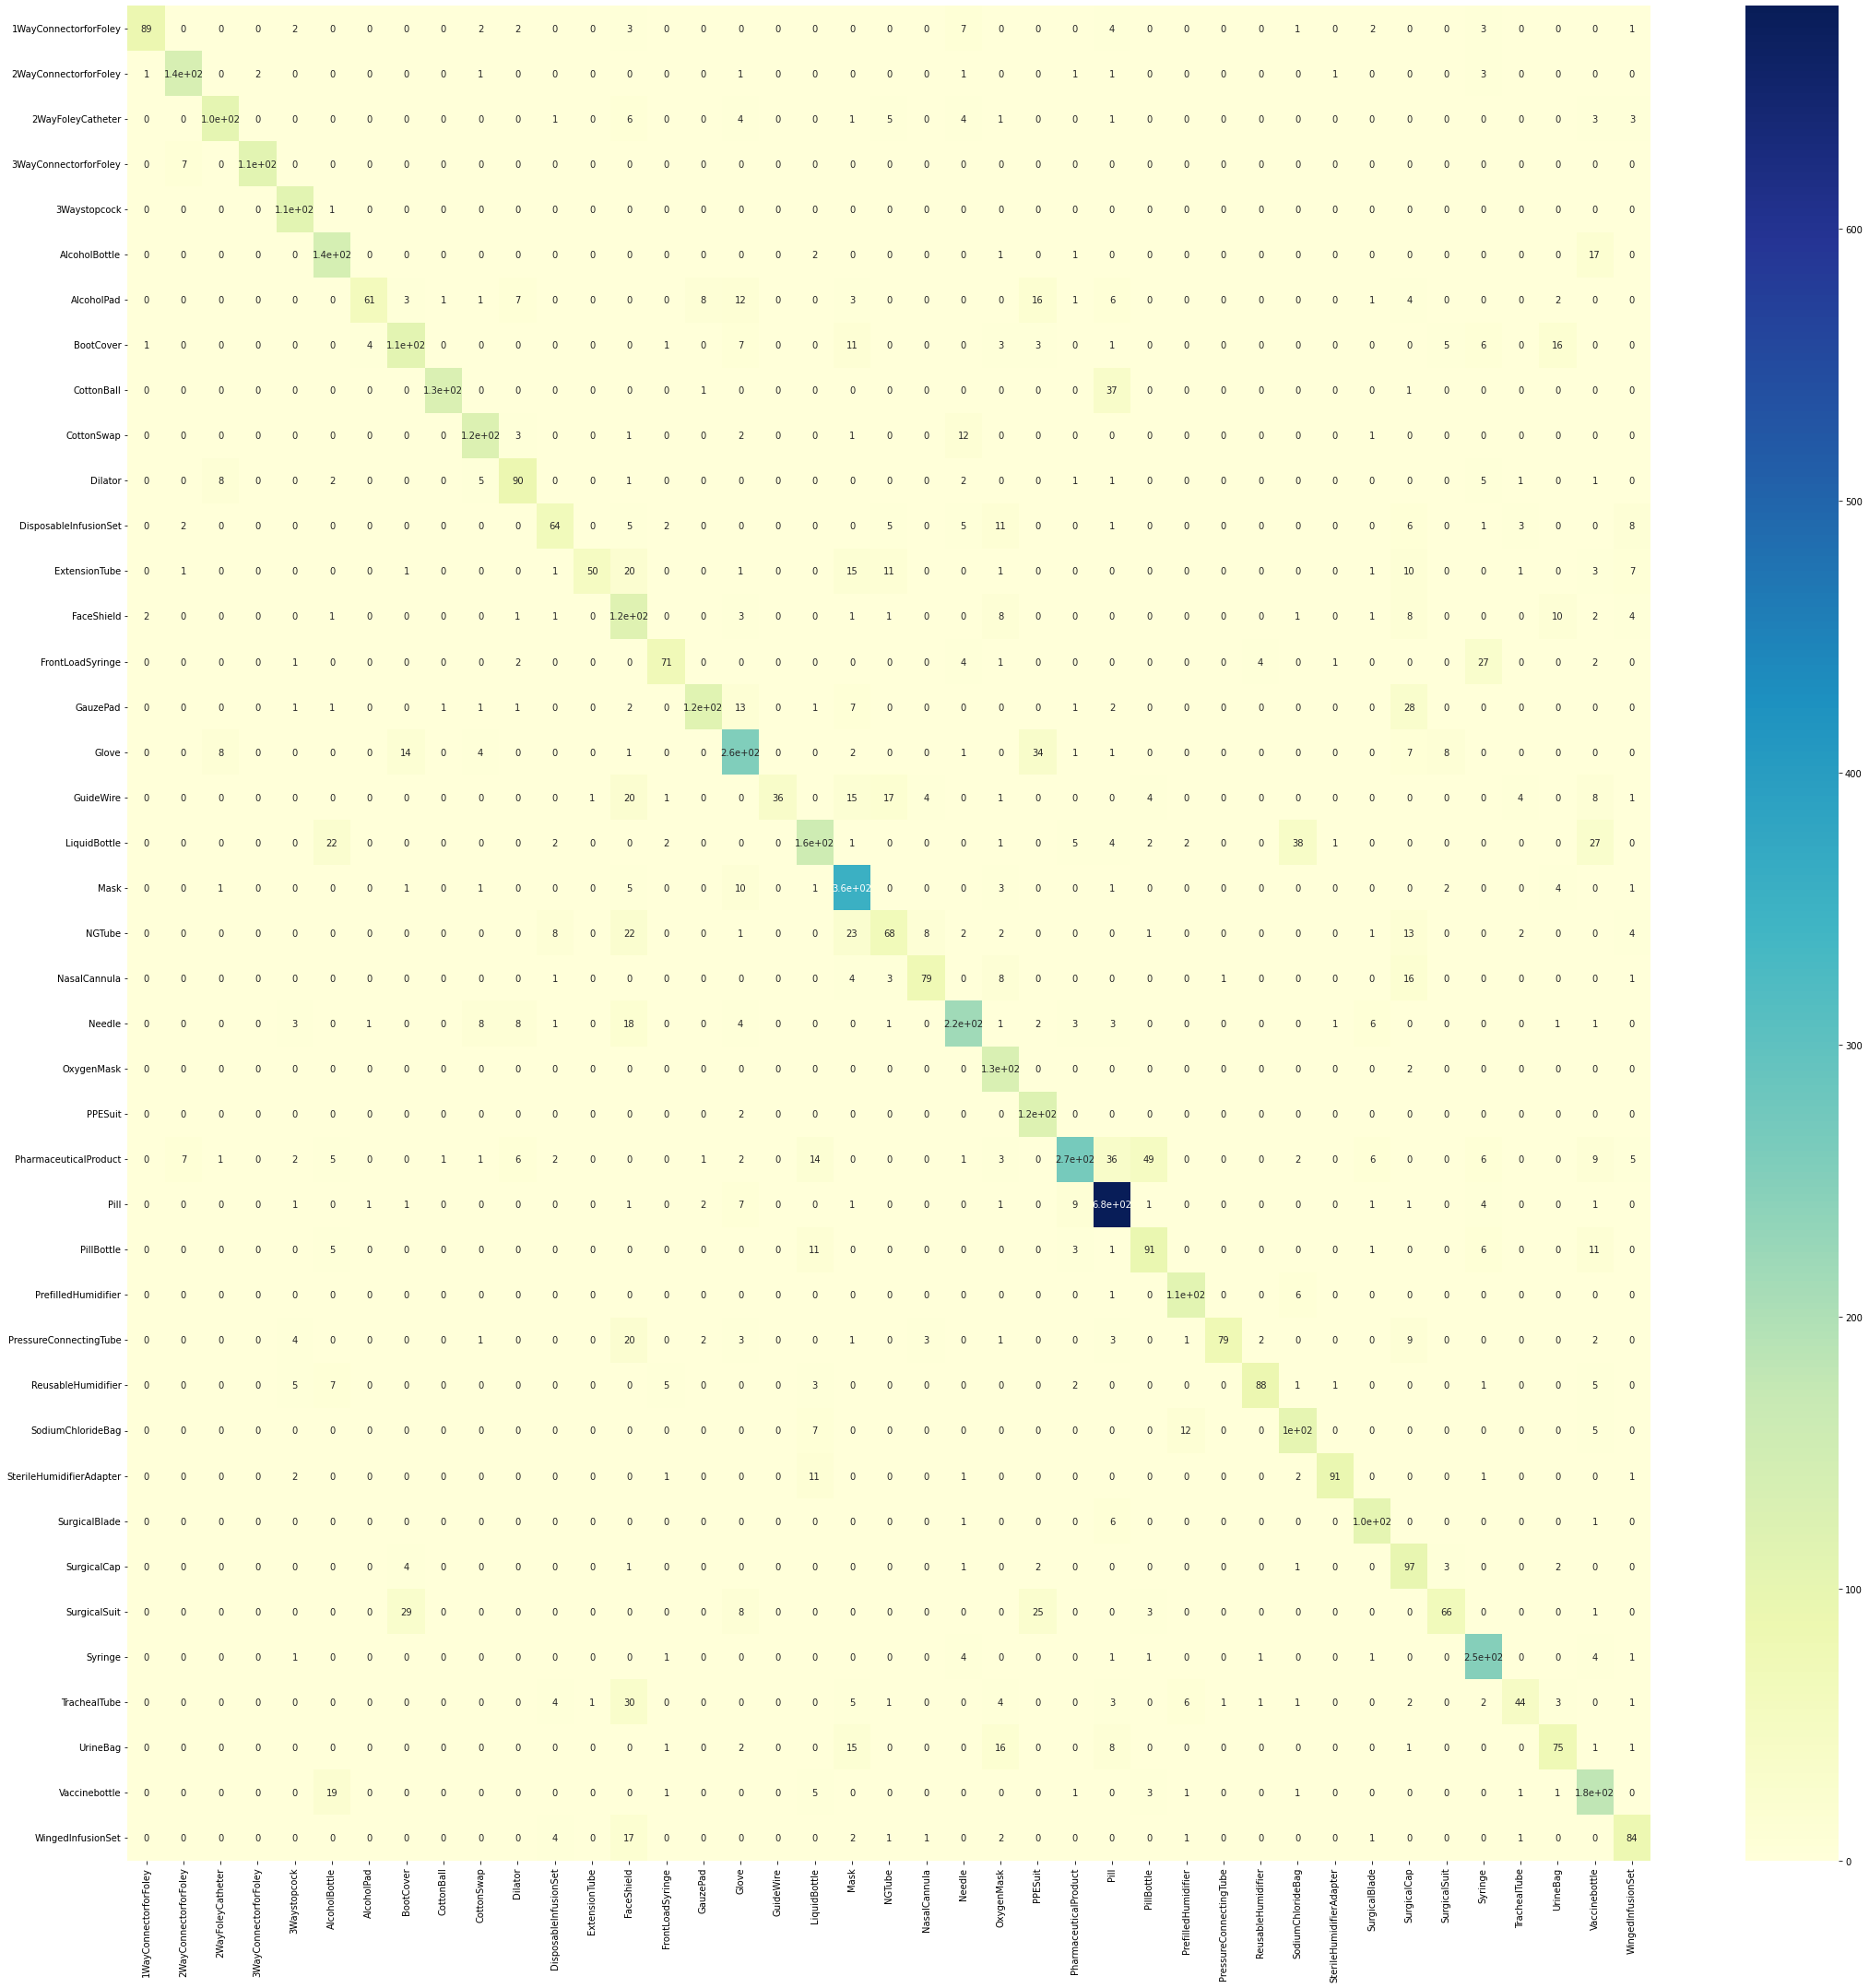

In [15]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

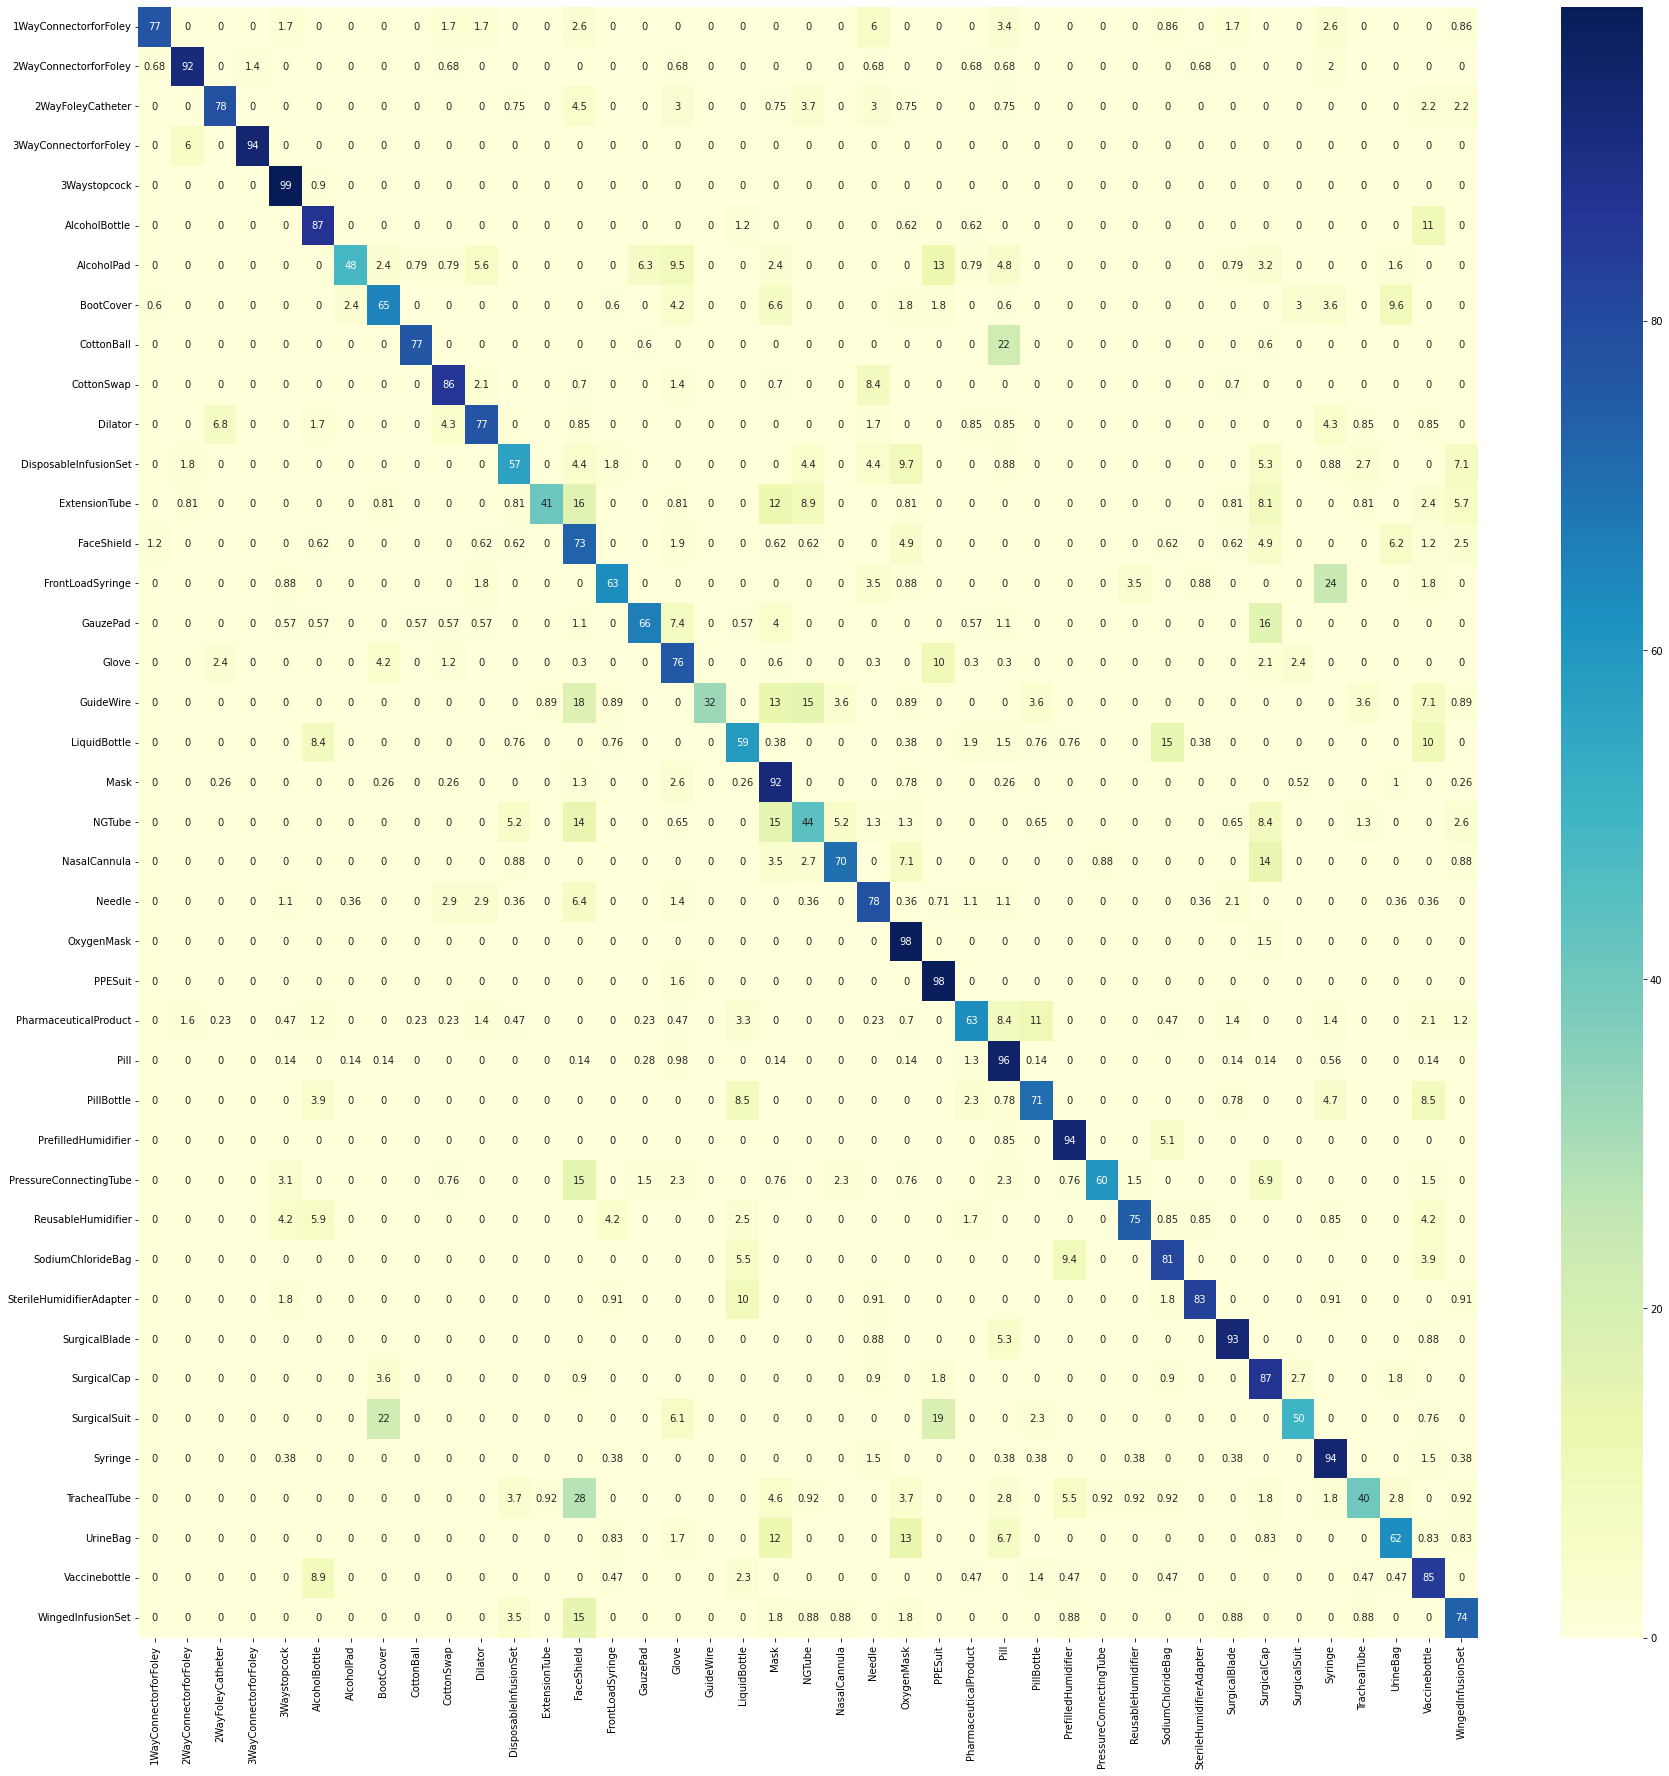

In [16]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")